In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

sns.set(style = 'darkgrid')

In [3]:
con = psycopg2.connect(dbname='mimic', user='sudarshan', host='/var/run/postgresql')

In [4]:
df = pd.read_sql_query("select count(distinct text) as n_notes, count(distinct hadm_id) as n_adms from co where length(text) between 100 and 8500;", con)
n_notes, n_adms = df['n_notes'][0], df['n_adms'][0]

In [5]:
def plot_intervals(df, cat, ax):    
    sns.barplot(x='days', y='n_notes', data=df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax.set_xlabel("days")
    ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
    ax.set_title(f"Note Category: {cat}\nTotal number of notes: {df['n_notes'].sum()}", fontweight='bold', fontsize=15)                

    for index, (_, row) in enumerate(df.iterrows()):
        ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)
    return ax

In [6]:
query = """
select category, chartinterval, count(distinct text) as n_notes from co where length(text) between 100 and 8500 group by category, chartinterval order by category, chartinterval;
"""
df = pd.read_sql_query(query, con)

intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≤ -15')

df['days'] = df['chartinterval'].apply(lambda x: intervals[x])
df.drop(['chartinterval'], inplace=True, axis=1)
df['log_notes'] = np.log(df['n_notes'])
df.head()

,category,n_notes,days,log_notes
0,Case Management,1,-2 ≤ t ≤ -1,0.000000
1,Case Management,2,-3 ≤ t ≤ -2,0.693147
2,Case Management,2,-4 ≤ t ≤ -3,0.693147
3,Case Management,4,-5 ≤ t ≤ -4,1.386294
4,Case Management,3,-6 ≤ t ≤ -5,1.098612


In [7]:
print(df['category'].nunique())
sorted(df['category'].unique())

12


['Case Management ',
 'Consult',
 'General',
 'Nursing',
 'Nursing/other',
 'Nutrition',
 'Pharmacy',
 'Physician ',
 'Radiology',
 'Rehab Services',
 'Respiratory ',
 'Social Work']

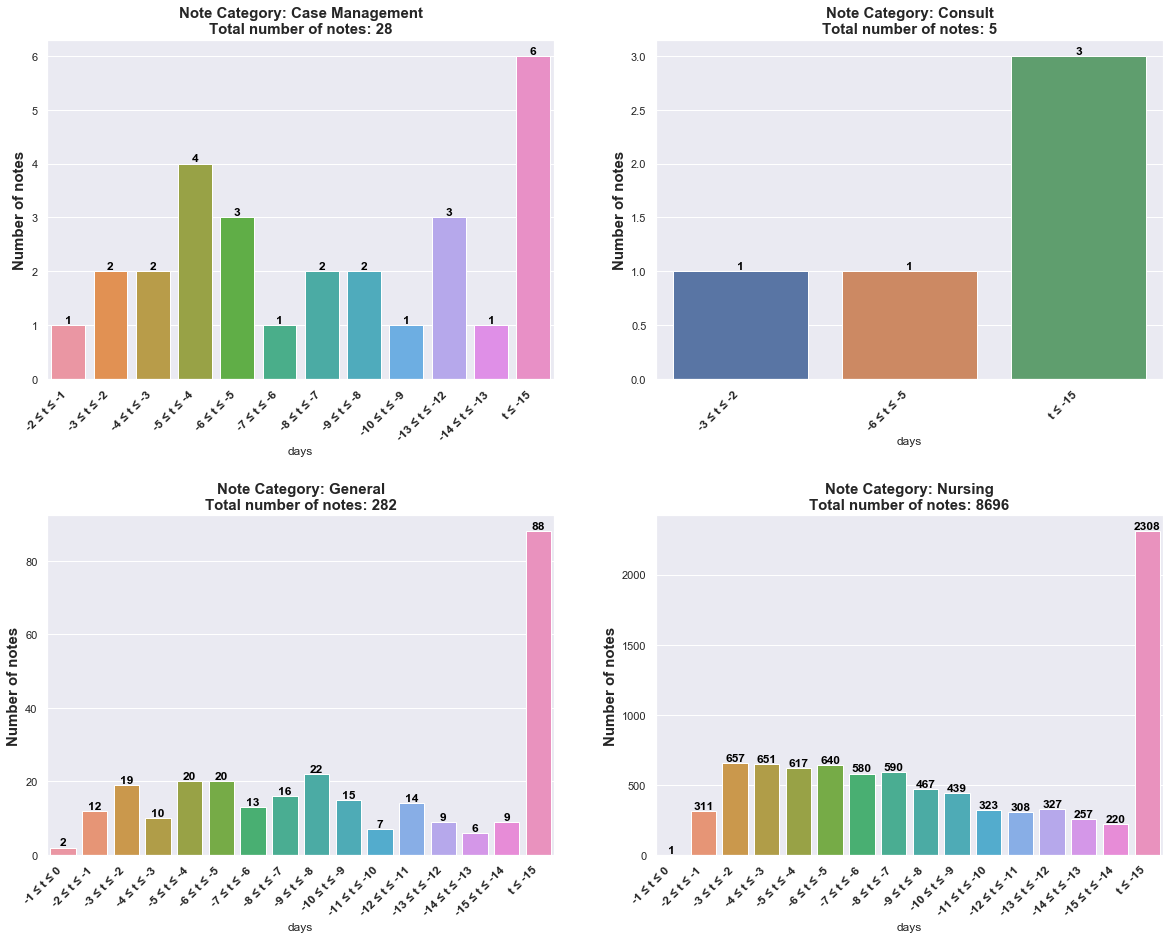

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_intervals(df.loc[df['category'] == 'Case Management ', ['n_notes', 'days', 'log_notes']], 'Case Management', ax[0][0])
plot_intervals(df.loc[df['category'] == 'Consult', ['n_notes', 'days', 'log_notes']], 'Consult', ax[0][1])
plot_intervals(df.loc[df['category'] == 'General', ['n_notes', 'days', 'log_notes']], 'General', ax[1][0])
plot_intervals(df.loc[df['category'] == 'Nursing', ['n_notes', 'days', 'log_notes']], 'Nursing', ax[1][1])
plt.subplots_adjust(hspace = 0.4)

fig.savefig('cats_1.tif', dpi=300)
fig.savefig('cats_1.eps', dpi=300)

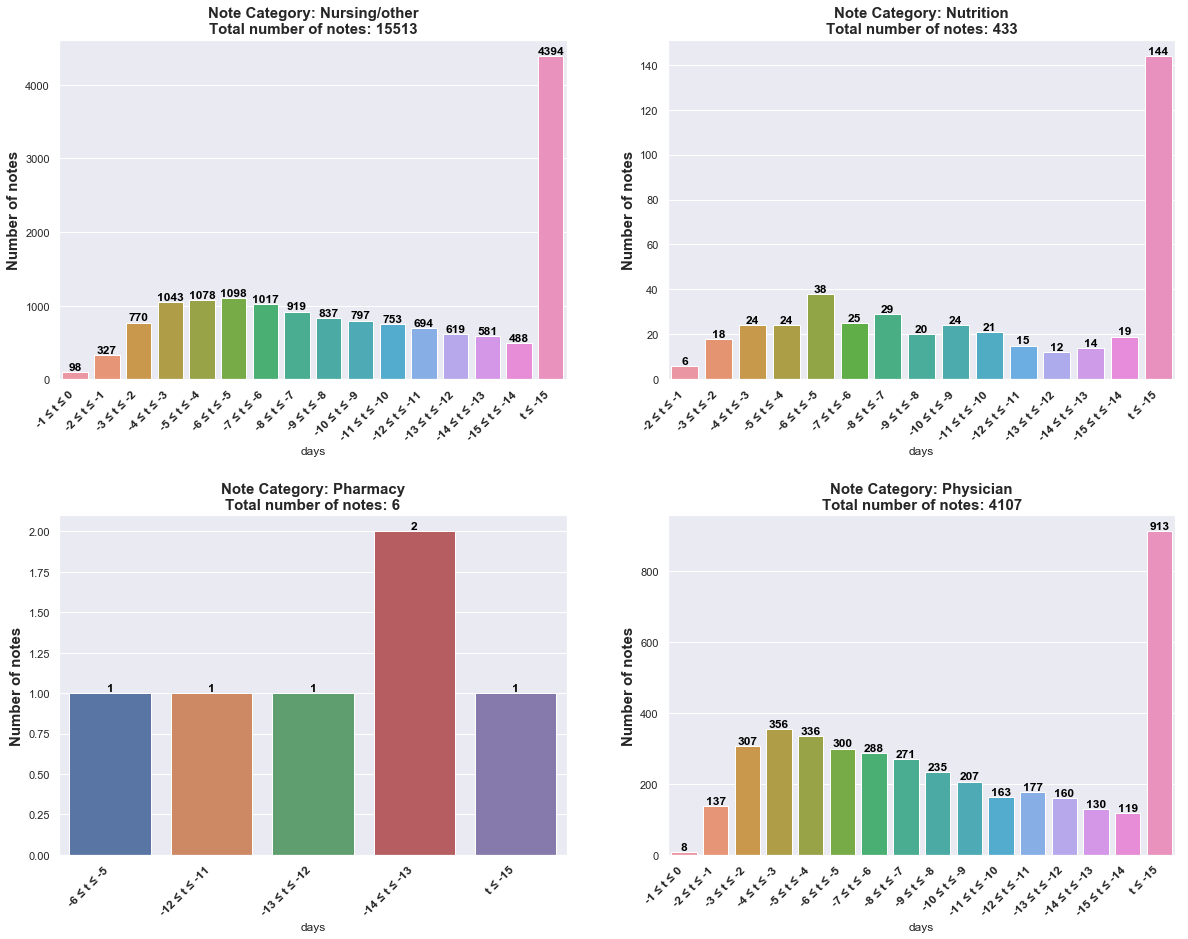

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_intervals(df.loc[df['category'] == 'Nursing/other', ['n_notes', 'days', 'log_notes']], 'Nursing/other', ax[0][0])
plot_intervals(df.loc[df['category'] == 'Nutrition', ['n_notes', 'days', 'log_notes']], 'Nutrition', ax[0][1])
plot_intervals(df.loc[df['category'] == 'Pharmacy', ['n_notes', 'days', 'log_notes']], 'Pharmacy', ax[1][0])
plot_intervals(df.loc[df['category'] == 'Physician ', ['n_notes', 'days', 'log_notes']], 'Physician', ax[1][1])
plt.subplots_adjust(hspace = 0.4)

fig.savefig('cats_2.tif', dpi=300)
fig.savefig('cats_2.eps', dpi=300)

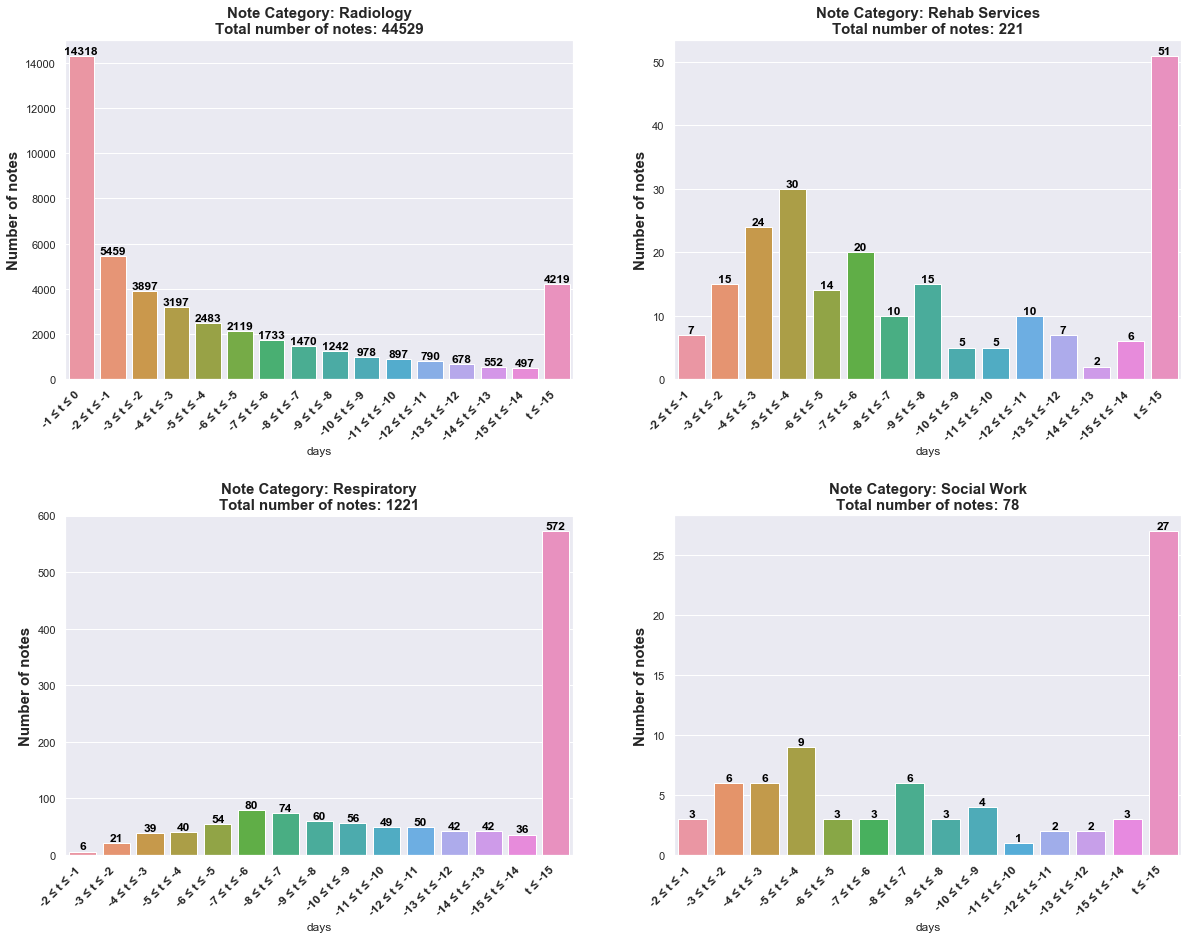

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_intervals(df.loc[df['category'] == 'Radiology', ['n_notes', 'days', 'log_notes']], 'Radiology', ax[0][0])
plot_intervals(df.loc[df['category'] == 'Rehab Services', ['n_notes', 'days', 'log_notes']], 'Rehab Services', ax[0][1])
plot_intervals(df.loc[df['category'] == 'Respiratory ', ['n_notes', 'days', 'log_notes']], 'Respiratory', ax[1][0])
plot_intervals(df.loc[df['category'] == 'Social Work', ['n_notes', 'days', 'log_notes']], 'Social Work', ax[1][1])
plt.subplots_adjust(hspace = 0.4)

fig.savefig('cats_3.tif', dpi=300)
fig.savefig('cats_3.eps', dpi=300)

In [17]:
def plot_wait_time(df, cat, ax):
    sns.distplot(df, kde=False, ax=ax, bins=10)
    ax.set_xlabel('Time between note charttime and ICU intime (days)', fontweight='bold', fontsize=15)
    ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
#     ax.set_title(f"Histogram of Chart Interval for cateogry {cat}\nMin: {df['chart_icu_period'].min()}, Avg: {df['note_wait_time'].mean():0.2f}, Max:{df['note_wait_time'].max()}", fontweight='bold', fontsize=15)

In [13]:
query = """
select category, chart_icu_period from co where length(text) between 100 and 8500;
"""
df = pd.read_sql_query(query, con)
df.head()

,category,chart_icu_period
0,Radiology,0.62
1,Radiology,0.09
2,Radiology,1.76
3,Radiology,0.90
4,Radiology,0.05


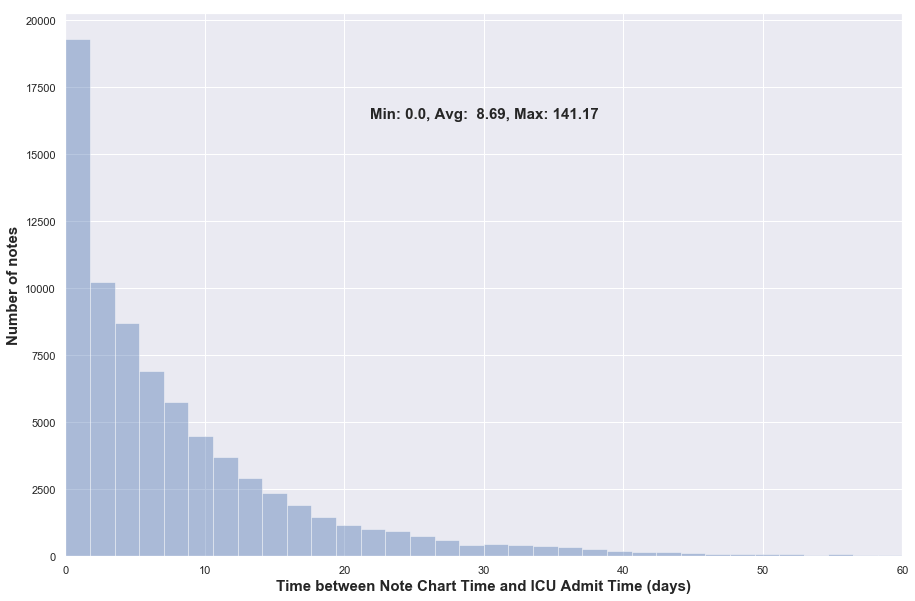

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
mdf = df[['chart_icu_period']]
# mdf = np.log1p(df[['note_wait_time']])

sns.distplot(mdf, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time between Note Chart Time and ICU Admit Time (days)', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
# ax.set_title('Histogram of Chart Interval', fontweight='bold', fontsize=15)
# ax.set_xscale('log')
ax.set_xlim(0, 60)

ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['chart_icu_period'].min()}, Avg: {mdf['chart_icu_period'].mean(): 0.2f}, Max: {mdf['chart_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

fig.savefig('chart_icu_period.tif', dpi=300)
fig.savefig('chart_icu_period.eps', dpi=300)

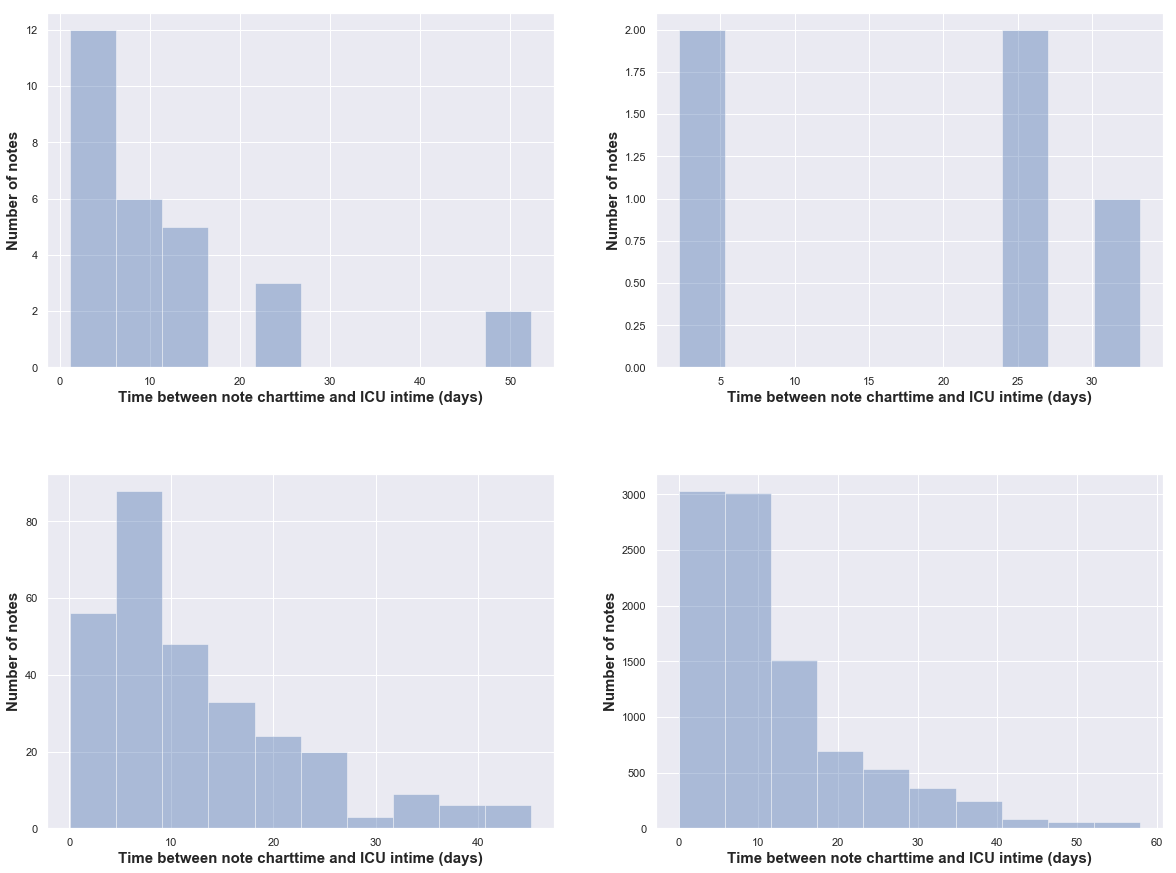

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_wait_time(df.loc[df['category'] == 'Case Management ', ['chart_icu_period']], 'Case Management', ax[0][0])
plot_wait_time(df.loc[df['category'] == 'Consult', ['chart_icu_period']], 'Consult', ax[0][1])
plot_wait_time(df.loc[df['category'] == 'General', ['chart_icu_period']], 'General', ax[1][0])
plot_wait_time(df.loc[df['category'] == 'Nursing', ['chart_icu_period']], 'Nursing', ax[1][1])
plt.subplots_adjust(hspace = 0.3)

fig.savefig('cats_period_1.tif', dpi=300)
fig.savefig('cats_period_1.eps', dpi=300)

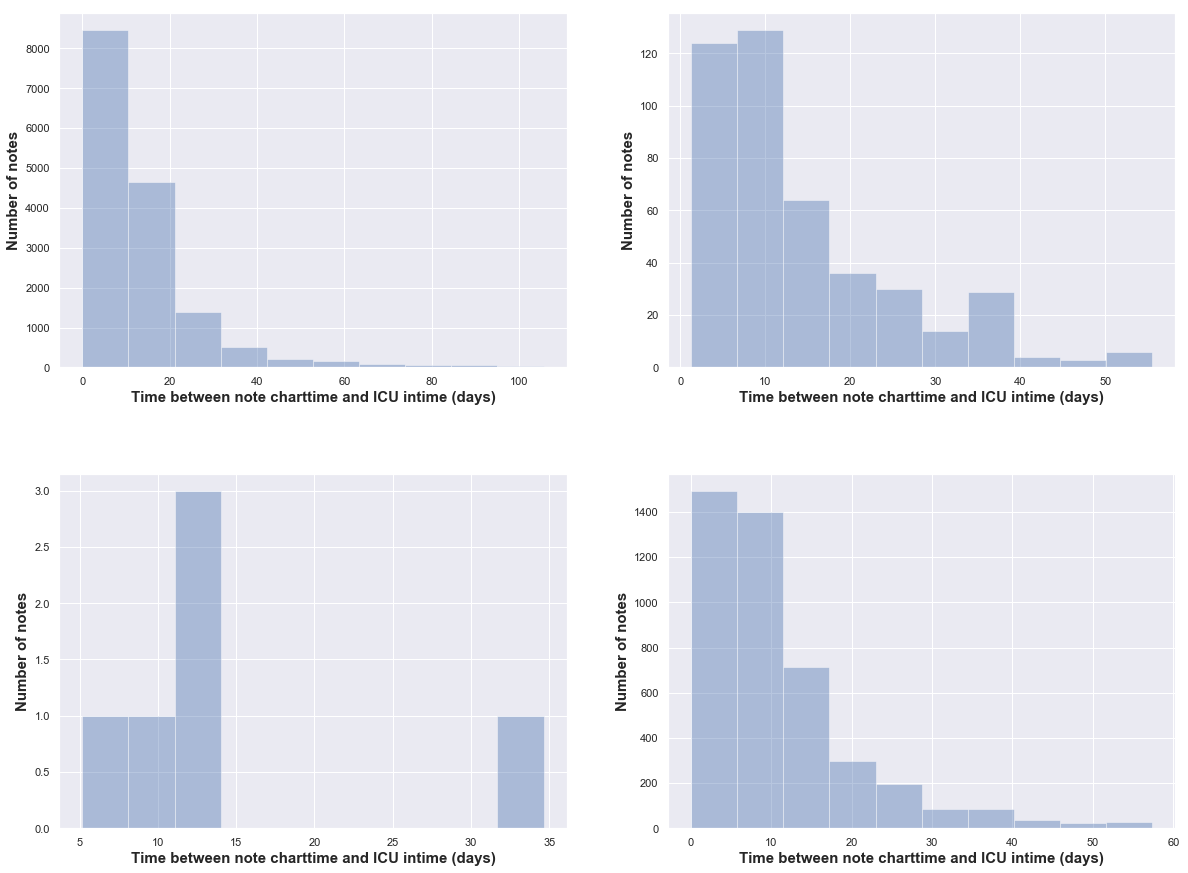

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_wait_time(df.loc[df['category'] == 'Nursing/other', ['chart_icu_period']], 'Nursing/other', ax[0][0])
plot_wait_time(df.loc[df['category'] == 'Nutrition', ['chart_icu_period']], 'Nutrition', ax[0][1])
plot_wait_time(df.loc[df['category'] == 'Pharmacy', ['chart_icu_period']], 'Pharmacy', ax[1][0])
plot_wait_time(df.loc[df['category'] == 'Physician ', ['chart_icu_period']], 'Physician', ax[1][1])
plt.subplots_adjust(hspace = 0.3)

fig.savefig('cats_period_2.tif', dpi=300)
fig.savefig('cats_period_2.eps', dpi=300)

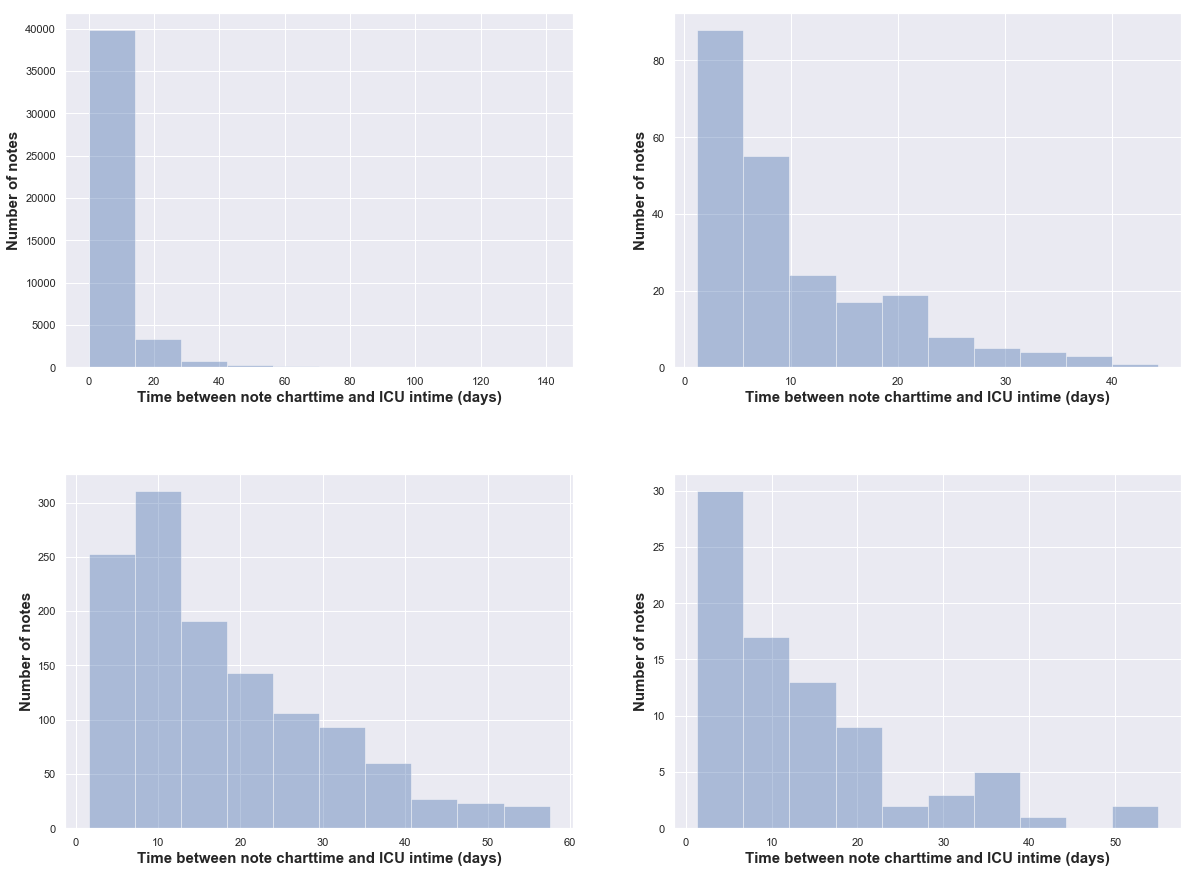

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plot_wait_time(df.loc[df['category'] == 'Radiology', ['chart_icu_period']], 'Radiology', ax[0][0])
plot_wait_time(df.loc[df['category'] == 'Rehab Services', ['chart_icu_period']], 'Rehab Services', ax[0][1])
plot_wait_time(df.loc[df['category'] == 'Respiratory ', ['chart_icu_period']], 'Respiratory', ax[1][0])
plot_wait_time(df.loc[df['category'] == 'Social Work', ['chart_icu_period']], 'Social Work', ax[1][1])
plt.subplots_adjust(hspace = 0.3)

fig.savefig('cats_period_3.tif', dpi=300)
fig.savefig('cats_period_3.eps', dpi=300)

In [25]:
query = """
select adm_icu_period from co where length(text) between 100 and 8500;
"""
df = pd.read_sql_query(query, con)
df.head()

,adm_icu_period
0,0.77
1,0.77
2,1.96
3,1.96
4,0.27


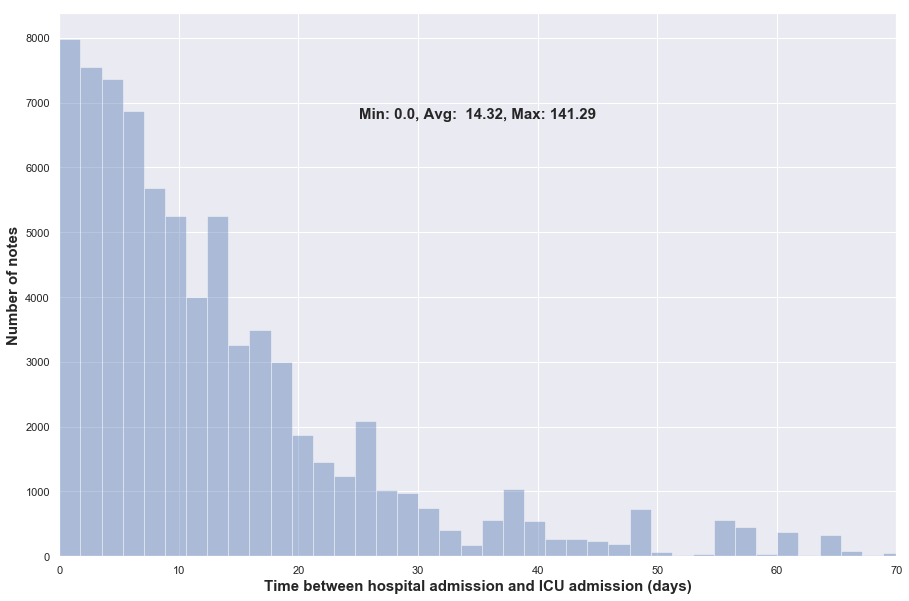

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
mdf = df[['adm_icu_period']]
# mdf = np.log1p(df[['note_wait_time']])

sns.distplot(mdf, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time between hospital admission and ICU admission (days)', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
# ax.set_title('Histogram of Wait Period', fontweight='bold', fontsize=15)
# ax.set_xscale('log')
ax.set_xlim(0, 70)

ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['adm_icu_period'].min()}, Avg: {mdf['adm_icu_period'].mean(): 0.2f}, Max: {mdf['adm_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')
        
fig.savefig('adm_icu_period.tif', dpi=300)
fig.savefig('adm_icu_period.eps', dpi=300)

In [27]:
query = """
select length(text) as note_length from co where length(text) between 100 and 8500;
"""
df = pd.read_sql_query(query, con)
df.head()

,note_length
0,1327
1,1623
2,1095
3,1611
4,1355


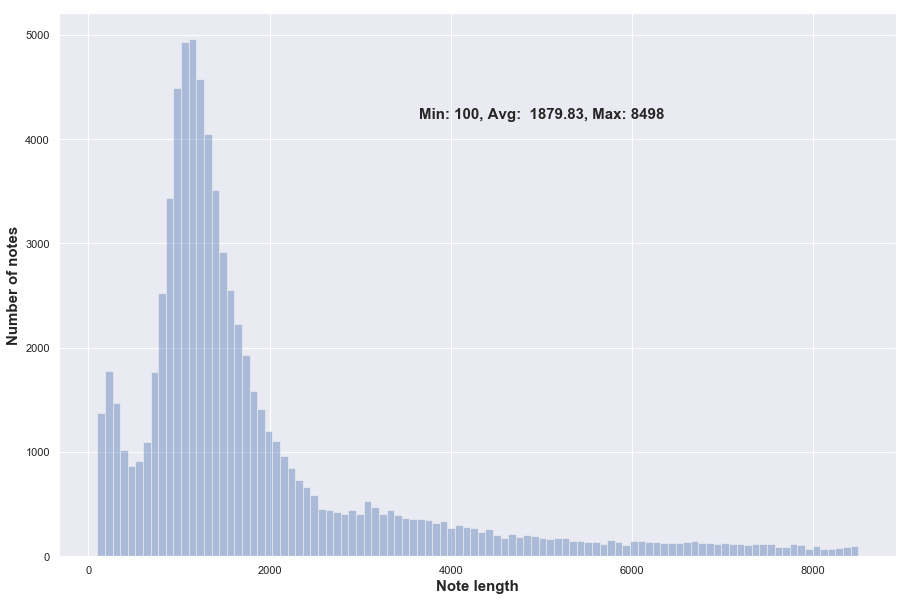

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['note_length'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Note length', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
# ax.set_title('Histogram of note length', fontweight='bold', fontsize=15)
# ax.set_xlim(0, 11000)

ax.text(5000, ax.get_ylim()[1]*0.80, f"Min: {df['note_length'].min()}, Avg: {df['note_length'].mean(): 0.2f}, Max: {df['note_length'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')
        
fig.savefig('note_len_hist.tif', dpi=300)
fig.savefig('note_len_hist.eps', dpi=300)

In [29]:
query = """
select count(distinct text) as n_notes, count(distinct hadm_id) as n_adms, class_label from co where length(text) between 100 and 8500 group by class_label order by class_label
"""
df = pd.read_sql_query(query, con)

In [30]:
desc = ['not used', 'negative class', 'positive class']
df['class_label'] = desc
df = df.reindex([2,1,0])
df.reset_index(inplace=True, drop=True)
df

,n_notes,n_adms,class_label
0,11976,5516,positive class
1,38670,3035,negative class
2,24410,10581,not used


In [31]:
mdf = df.copy()
mdf.rename(columns={'adms':'Number of Admissions', 'n_notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='class_label', var_name='Legend', value_name='counts')

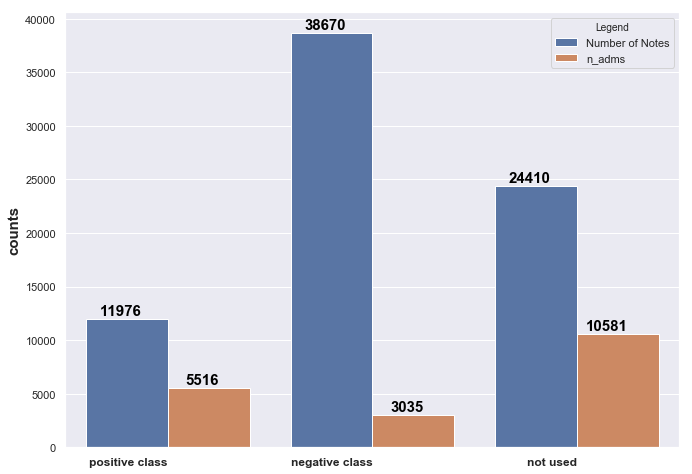

In [33]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.barplot(x='class_label', y='counts', hue='Legend', data=mdf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontweight='bold', fontsize=12)
ax.set_xlabel("")
ax.set_ylabel('counts', fontweight='bold', fontsize=15)
# ax.set_title('Distribution of notes and admissions w.r.t class labels', fontweight='bold', fontsize=15)

for index, row in mdf.iterrows():
    if index < len(mdf)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=15)
    else:
        ax.text(index % (len(mdf)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=15)
        
fig.savefig('note_class_dist.tif', dpi=300)
fig.savefig('note_class_dist.eps', dpi=300)        

In [38]:
def plot_intervals_all(df, mdf):    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))

    sns.barplot(x='days', y='n_notes', data=df, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[0].set_xlabel("")
    ax[0].set_ylabel('Number of notes', fontweight='bold', fontsize=15)
#     ax[0].set_title('Distribution of notes and admissions w.r.t chart time and ICU admit time (in days)', fontweight='bold', fontsize=15)

#     ax[0].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in df.iterrows():
        ax[0].text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

    sns.barplot(x='days', y='counts', hue='Legend', data=mdf, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[1].set_xlabel("Time between note chart time and ICU admit time (days)\n 't' is the time-to-ICU admit time", fontweight='bold', fontsize=15)
    ax[1].set_ylabel('count', fontweight='bold', fontsize=15)

#     ax[1].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}\nTotal number of hospital admissions = {n_adms}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in mdf.iterrows():
        if index < len(mdf)//2:
            ax[1].text(index+0.04, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)
        else:
            ax[1].text(index % (len(mdf)//2) + 0.36, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)
    fig.savefig('notes_adm_icu_period.tif', dpi=300)
    fig.savefig('notes_adm_icu_period.eps', dpi=300)                 

In [35]:
query = """
select count(distinct text) as n_notes, count(distinct hadm_id) as n_adms from co where length(text) between 100 and 8500 group by chartinterval order by chartinterval;
"""
df = pd.read_sql_query(query, con)
df['days'] = intervals

In [36]:
# df.drop(0, axis=0, inplace=True)
# df.reset_index(inplace=True, drop=True)

mdf = df.copy()
mdf.rename(columns={'n_adms':'Number of Admissions', 'n_notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='days', var_name='Legend', value_name='counts')

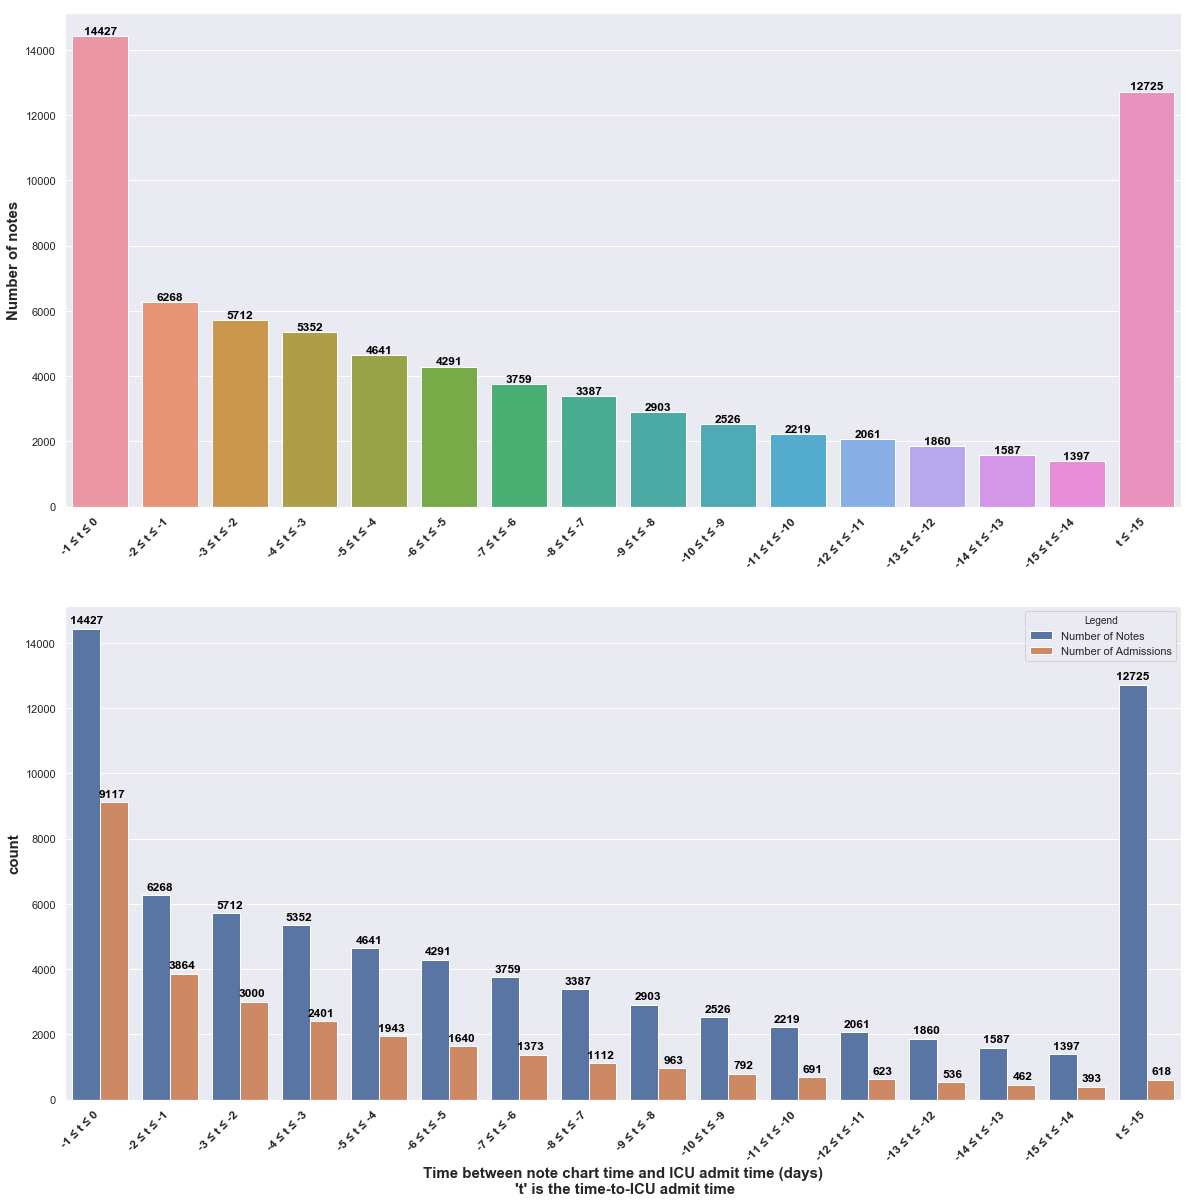

In [39]:
plot_intervals_all(df, mdf)

In [40]:
con.close()